In [1]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
with uproot.open("../pythia/output/dataset_diHiggs_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    jet_pufr = f["jet_pufr_truth"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_m = f["jet_m"].array()

In [3]:
JVT_pufr = np.array(ak.ravel(jet_pufr))
JVT_corrJVF = np.array(ak.ravel(jet_corrJVF))
JVT_RpT = np.array(ak.ravel(jet_RpT))

In [4]:
threshold = 0.7

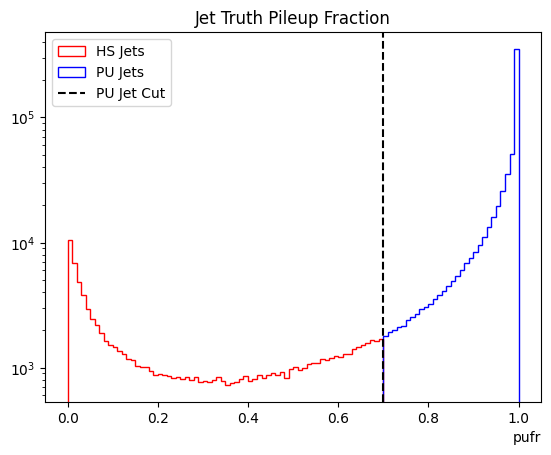

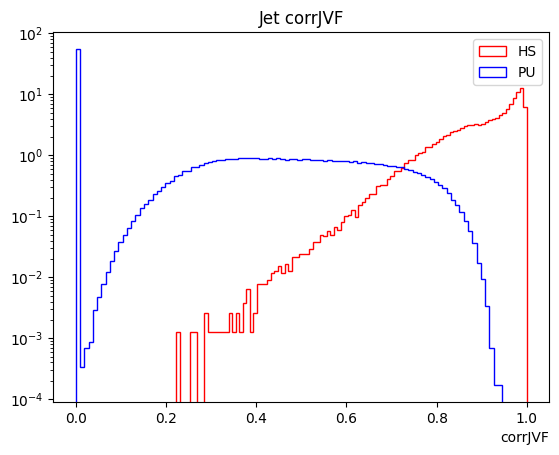

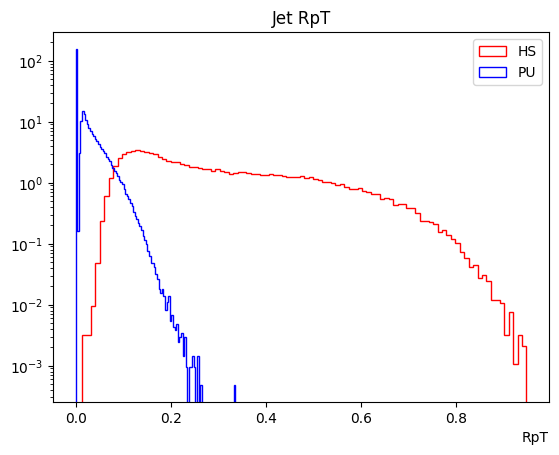

In [5]:
sig = (JVT_pufr < threshold)
bkg = ~sig

plt.title("Jet Truth Pileup Fraction")
plt.hist(JVT_pufr[sig],histtype='step',bins=int(100*threshold),label='HS Jets',color='r')
plt.hist(JVT_pufr[bkg],histtype='step',bins=int(100*(1-threshold)),label='PU Jets',color='b')

plt.axvline(x = threshold, color = 'k', label = 'PU Jet Cut',linestyle='dashed')
plt.xlabel("pufr",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

plt.title("Jet corrJVF")
plt.hist(JVT_corrJVF[sig],bins=100,histtype='step',label='HS',density=True,color='r')
plt.hist(JVT_corrJVF[bkg],bins=100,histtype='step',label='PU',density=True,color='b')
plt.xlabel("corrJVF",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

plt.title("Jet RpT")
plt.hist(JVT_RpT[sig],bins=100,histtype='step',label='HS',density=True,color='r')
plt.hist(JVT_RpT[bkg],bins=100,histtype='step',label='PU',density=True,color='b')
plt.xlabel("RpT",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

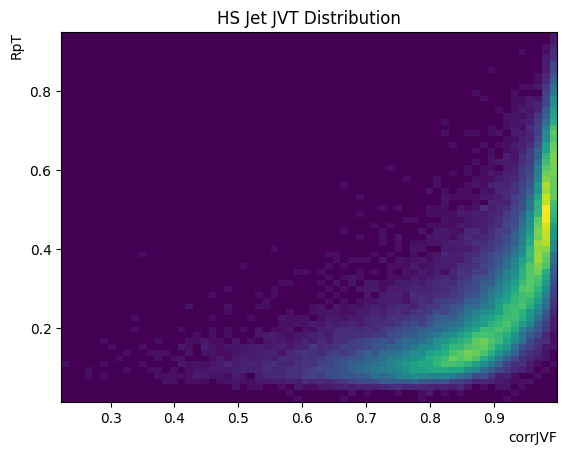

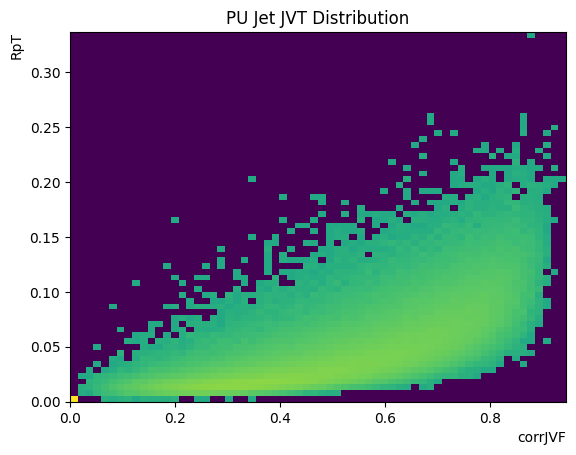

In [6]:
sig = (JVT_pufr < threshold)
bkg = ~sig

gamma_sig = 0.5
plt.title("HS Jet JVT Distribution")
plt.hist2d(JVT_corrJVF[sig],JVT_RpT[sig],bins=64,density=True,norm=mcolors.PowerNorm(gamma_sig))
plt.xlabel("corrJVF",loc='right')
plt.ylabel("RpT",loc='top')
#plt.colorbar()
plt.show()

gamma_bkg = 0.04
plt.title("PU Jet JVT Distribution")
plt.hist2d(JVT_corrJVF[bkg],JVT_RpT[bkg],bins=64,density=True,norm=mcolors.PowerNorm(gamma_bkg))
plt.xlabel("corrJVF",loc='right')
plt.ylabel("RpT",loc='top')
plt.show()

In [7]:
X = np.vstack((JVT_corrJVF,JVT_RpT)).T
y = (JVT_pufr < threshold).astype(float)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]
JVT_pufr = JVT_pufr[p]
JVT_RpT = JVT_RpT[p]
JVT_corrJVF = JVT_corrJVF[p]

# Total 10k events
num_train = int(len(X) - 0.25*len(X))

X_train_JVT = X[0:num_train]
y_train_JVT = y[0:num_train]

X_test_JVT = X[num_train:]
y_test_JVT = y[num_train:]

kNN = KNeighborsClassifier(n_neighbors=100)

kNN.fit(X_train_JVT,y_train_JVT)

KNeighborsClassifier(n_neighbors=100)

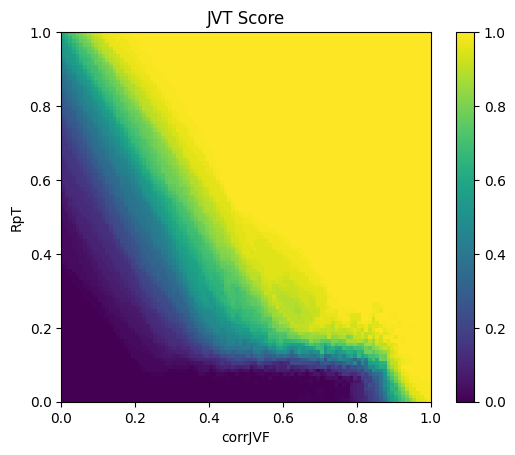

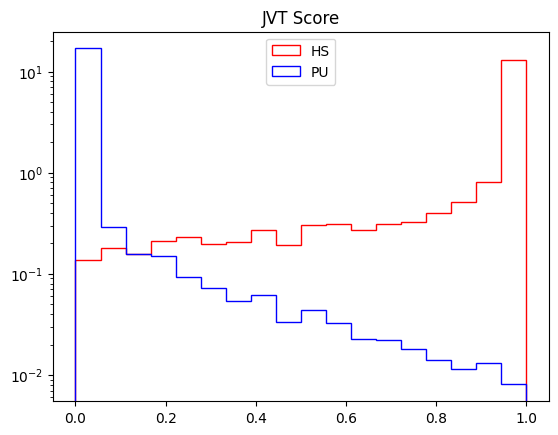

In [8]:
x = np.linspace(0,1,100)
y = np.flip(np.linspace(0,1,100))

xv, yv = np.meshgrid(x,y, copy=True)

zv = np.zeros_like(xv)

for i in range(len(x)):
    for j in range(len(y)):
        zv[j,i] = kNN.predict_proba([[x[i],y[j]]])[:,1][0]

plt.title("JVT Score")
plt.imshow(zv, extent=[0, 1, 0, 1])

plt.xlabel("corrJVF")
plt.ylabel("RpT")
plt.colorbar()
plt.show()

y_pred = kNN.predict_proba(X_test_JVT)
plt.title("JVT Score")
plt.hist(y_pred[:,1][y_test_JVT==1],bins=18,histtype='step',label='HS',density=True,color='r')
plt.hist(y_pred[:,1][y_test_JVT==0],bins=18,histtype='step',label='PU',density=True,color='b')
plt.legend(loc='upper center')
plt.yscale('log')
plt.show()

In [9]:
Attn_label = ak.values_astype((jet_pufr < threshold), int)

num_feats = 6
mean_list = []
std_list = []
feat_list = [jet_corrJVF,jet_RpT,jet_pt,jet_eta,jet_phi,jet_m]
norm_list = []
for feat in feat_list:
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm_list.append(((feat-mean)/std))    
    

feat_names = ["corrJVF","RpT","pT","eta","phi","m"]

plot=False
if plot:
    for i in range(num_feats):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

        ax1.set_title(feat_names[i])
        ax1.hist(ak.ravel(feat_list[i][Attn_label==1]),histtype='step',label='HS',density=True,bins=10)
        ax1.hist(ak.ravel(feat_list[i][Attn_label==0]),histtype='step',label='PU',density=True,bins=10)
        ax1.legend()

        ax2.set_title("Norm "+feat_names[i])
        ax2.hist(ak.ravel(norm_list[i][Attn_label==1]),histtype='step',label='HS',density=True,bins=10)
        ax2.hist(ak.ravel(norm_list[i][Attn_label==0]),histtype='step',label='PU',density=True,bins=10)
        ax2.legend()

        plt.show()

        print("Mean Before: ", ak.mean(feat_list[i]), "\t\t Mean After: ", ak.mean(norm_list[i]))
        print("STD Before: ", ak.std(feat_list[i]), "\t\t STD After: ", ak.std(norm_list[i]))

In [10]:
num_events = len(jet_pt)
train_split = int(0.7*num_events)
test_split = int(0.75*num_events)

batch = False
if batch:
    minibatch_size = 64
    num_minibatches = int(train_split/minibatch_size)

    X_train = []
    y_train = []
    for b in range(num_minibatches):
        batch_data = []
        for feat in norm_list:
            data = feat[b*minibatch_size:(b+1)*minibatch_size]
            max_num_jets = ak.max(ak.num(data,axis=1))
            data_padded = ak.pad_none(data,max_num_jets,axis=1)
            batch_data.append(ak.fill_none(data_padded,0.0,axis=1)[:,:,np.newaxis])

        label = Attn_label[b*minibatch_size:(b+1)*minibatch_size]
        label_padded = ak.pad_none(label,max_num_jets,axis=1)
        label_padded = ak.fill_none(label_padded,0.0,axis=1)
        batch_labels= np.array(label_padded).reshape(minibatch_size,max_num_jets,1)

        feats = ak.concatenate(batch_data, axis=2)
        X_train.append(torch.Tensor(feats))
        y_train.append(torch.Tensor(batch_labels))

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
jet_feats = ak.concatenate(Norm_list, axis=2)

if not batch:
    X_train = jet_feats[0:train_split]
    X_train = torch.nested.nested_tensor(ak.to_list(X_train), dtype=torch.float32)    
    y_train = Attn_label[0:train_split]
    y_train = torch.nested.nested_tensor(ak.to_list(y_train), dtype=torch.float32)
    
X_val = jet_feats[train_split:test_split]
X_val = torch.nested.nested_tensor(ak.to_list(X_val), dtype=torch.float32)
y_val = Attn_label[train_split:test_split]
y_val = torch.nested.nested_tensor(ak.to_list(y_val), dtype=torch.float32)

X_test = jet_feats[test_split:]
X_test = torch.nested.nested_tensor(ak.to_list(X_test), dtype=torch.float32)
y_test = Attn_label[test_split:]
y_test = torch.nested.nested_tensor(ak.to_list(y_test), dtype=torch.float32)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [11]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, feats):
        context, weights = self.attention(feats, feats, feats)
        latent = feats + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class AttnModel(nn.Module):
    def __init__(self, in_feats, embed_dim, num_heads, out_classes):
        super(AttnModel, self).__init__()        
        self.preprocess = nn.Linear(in_feats,embed_dim)

        self.encoder1 = Encoder(embed_dim, num_heads)
        self.encoder2 = Encoder(embed_dim, num_heads)
        self.encoder3 = Encoder(embed_dim, num_heads)
        self.encoder4 = Encoder(embed_dim, num_heads)
        
        self.classifier = nn.Linear(embed_dim,out_classes)
    def forward(self, jet_feats,return_weights=False):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.preprocess(jet_feats))
        
        # Attention Encoder
        jet_embedding, jet_weights = self.encoder1(jet_embedding)
        #jet_embedding, jet_weights = self.encoder2(jet_embedding)
        #jet_embedding, jet_weights = self.encoder3(jet_embedding)
        #jet_embedding, jet_weights = self.encoder4(jet_embedding)

        # Classify
        output = F.sigmoid(self.classifier(jet_embedding))
        
        if return_weights:
            return output, jet_weights
        return output

In [12]:
class BaselineNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(BaselineNN, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))

        # Classify
        output = F.sigmoid(self.jet_classifier(jet_embedding))
        return output

In [13]:
def train(model, data, epochs=20, batched=False):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'val_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        if batched:
            num_train = len(X_train)
        else:
            num_train = X_train.size(0)
        model.train()
        for i in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[i].to(device))
            if batched:
                loss = loss_fn(output, y_train[i].to(device))
            else:
                loss = loss_fn(output, y_train[i].reshape(-1,1).to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].reshape(-1,1).to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['val_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

    return history

In [14]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [15]:
hidden_layer = 32
num_heads=8

model = AttnModel(6,hidden_layer,num_heads,1)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Attention Model Trainable Params: ", params)

fudge_factor = 1
baseline = BaselineNN(6,int(params/num_heads*fudge_factor),1)
print("Baseline Model Trainable Params: ", sum(p.numel() for p in baseline.parameters() if p.requires_grad))

Attention Model Trainable Params:  21377
Baseline Model Trainable Params:  21377


In [16]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

Epochs = 20

# Train baseline NN
print("Training BaselineNN")
baseline.to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.0001)
data = [X_train, y_train, X_val, y_val]
if not batch:
    baseline_history = train(baseline, data, epochs=Epochs)
if batch:
    baseline_history = train(baseline, data, epochs=Epochs,batched=True)
print()


Epochs = 40

# Train Attention Model
print("Training AttnJVT")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
data = [X_train, y_train, X_val, y_val]
if not batch:
    model_history = train(model, data, epochs=Epochs)
if batch:
    model_history = train(model, data, epochs=Epochs,batched=True)
print()

Training BaselineNN
Epoch: 1 	Train Loss: 0.0646 	Val Loss: 0.0579
Epoch: 2 	Train Loss: 0.0562 	Val Loss: 0.0576
Epoch: 3 	Train Loss: 0.0558 	Val Loss: 0.0574
Epoch: 4 	Train Loss: 0.0555 	Val Loss: 0.0572
Epoch: 5 	Train Loss: 0.0553 	Val Loss: 0.0571
Epoch: 6 	Train Loss: 0.0552 	Val Loss: 0.0571
Epoch: 7 	Train Loss: 0.0551 	Val Loss: 0.0571
Epoch: 8 	Train Loss: 0.055 	Val Loss: 0.057
Epoch: 9 	Train Loss: 0.055 	Val Loss: 0.057
Epoch: 10 	Train Loss: 0.0549 	Val Loss: 0.057
Epoch: 11 	Train Loss: 0.0549 	Val Loss: 0.057
Epoch: 12 	Train Loss: 0.0548 	Val Loss: 0.057
Epoch: 13 	Train Loss: 0.0548 	Val Loss: 0.057
Epoch: 14 	Train Loss: 0.0548 	Val Loss: 0.057
Epoch: 15 	Train Loss: 0.0547 	Val Loss: 0.057
Epoch: 16 	Train Loss: 0.0547 	Val Loss: 0.0569
Epoch: 17 	Train Loss: 0.0547 	Val Loss: 0.0569
Epoch: 18 	Train Loss: 0.0546 	Val Loss: 0.0569
Epoch: 19 	Train Loss: 0.0546 	Val Loss: 0.0569
Epoch: 20 	Train Loss: 0.0545 	Val Loss: 0.0569

Training AttnJVT
Epoch: 1 	Train Loss:

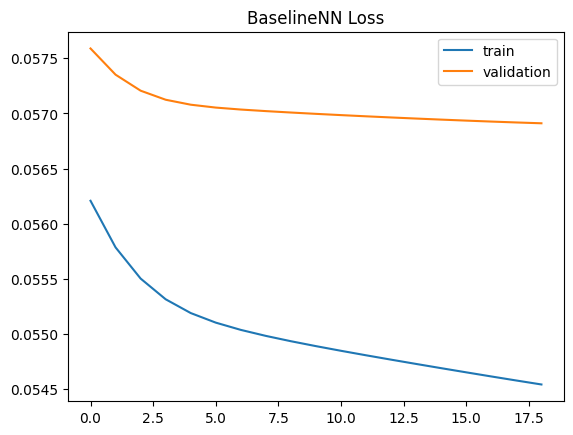

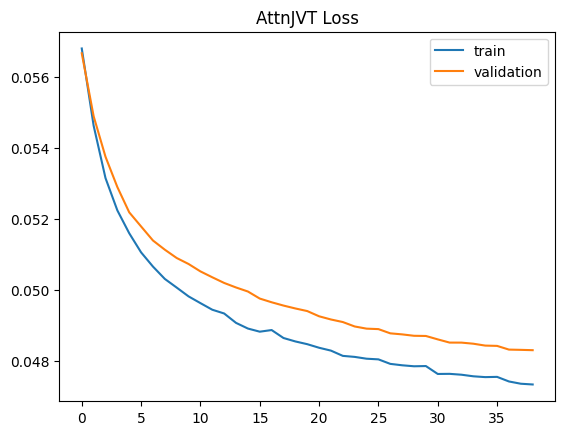

In [17]:
plt.plot(baseline_history['train_loss'][1:],label='train')
plt.plot(baseline_history['val_loss'][1:],label='validation')
plt.title("BaselineNN Loss")
plt.legend()
plt.show()

plt.plot(model_history['train_loss'][1:],label='train')
plt.plot(model_history['val_loss'][1:],label='validation')
plt.title("AttnJVT Loss")
plt.legend()
plt.show()

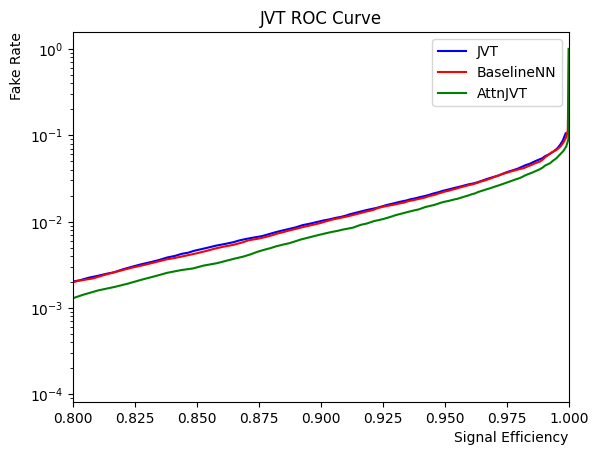

JVT Binary Accuracy: 			 0.9742986354688868
BaselineNN Binary Accuracy: 		 0.9768644936165499
Attention Model Binary Accuracy: 	 0.9791077016810213


In [18]:
def roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    fake_rate = []
    
    thresholds = np.linspace(0,0.97,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        fake_rate.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    return np.array(sig_eff), np.array(fake_rate), thresholds

y_pred_JVT = kNN.predict_proba(X_test_JVT)[:,1]

baseline.to(device)
model.to(device)

y_pred_baseline = []
y_pred_attn = []
weights = []
y_Test = []
for event in range(X_test.size(0)):
    y_pred_baseline.append(baseline(X_test[event].to(device)).detach().cpu().numpy())
    output, weight =model(X_test[event].to(device),return_weights=True)
    y_pred_attn.append(output.detach().cpu().numpy())
    weights.append(weight.detach().cpu().numpy())
    y_Test.append(y_test[event].detach().numpy())
    
y_pred_baseline = np.array(ak.ravel(y_pred_baseline))
y_pred_attn = np.array(ak.ravel(y_pred_attn))
y_Test = np.array(ak.ravel(y_Test))

x1,y1,th1 = roc(y_test_JVT,y_pred_JVT)
x2,y2,th2 = roc(y_Test,y_pred_baseline)
x3,y3,th3 = roc(y_Test,y_pred_attn)

plt.title("JVT ROC Curve")
plt.plot(x1,y1,color='b',label='JVT')
plt.plot(x2,y2,color='r',label='BaselineNN')
plt.plot(x3,y3,color='g',label='AttnJVT')

plt.ylabel('Fake Rate',loc='top')
plt.xlabel('Signal Efficiency',loc='right')
plt.yscale('log')
plt.legend()
plt.xlim([0.8, 1])
plt.show()
print("JVT Binary Accuracy: \t\t\t", accuracy_score(y_test_JVT, y_pred_JVT>threshold))
print("BaselineNN Binary Accuracy: \t\t", accuracy_score(y_Test, y_pred_baseline>threshold))
print("Attention Model Binary Accuracy: \t", accuracy_score(y_Test, y_pred_attn>threshold))

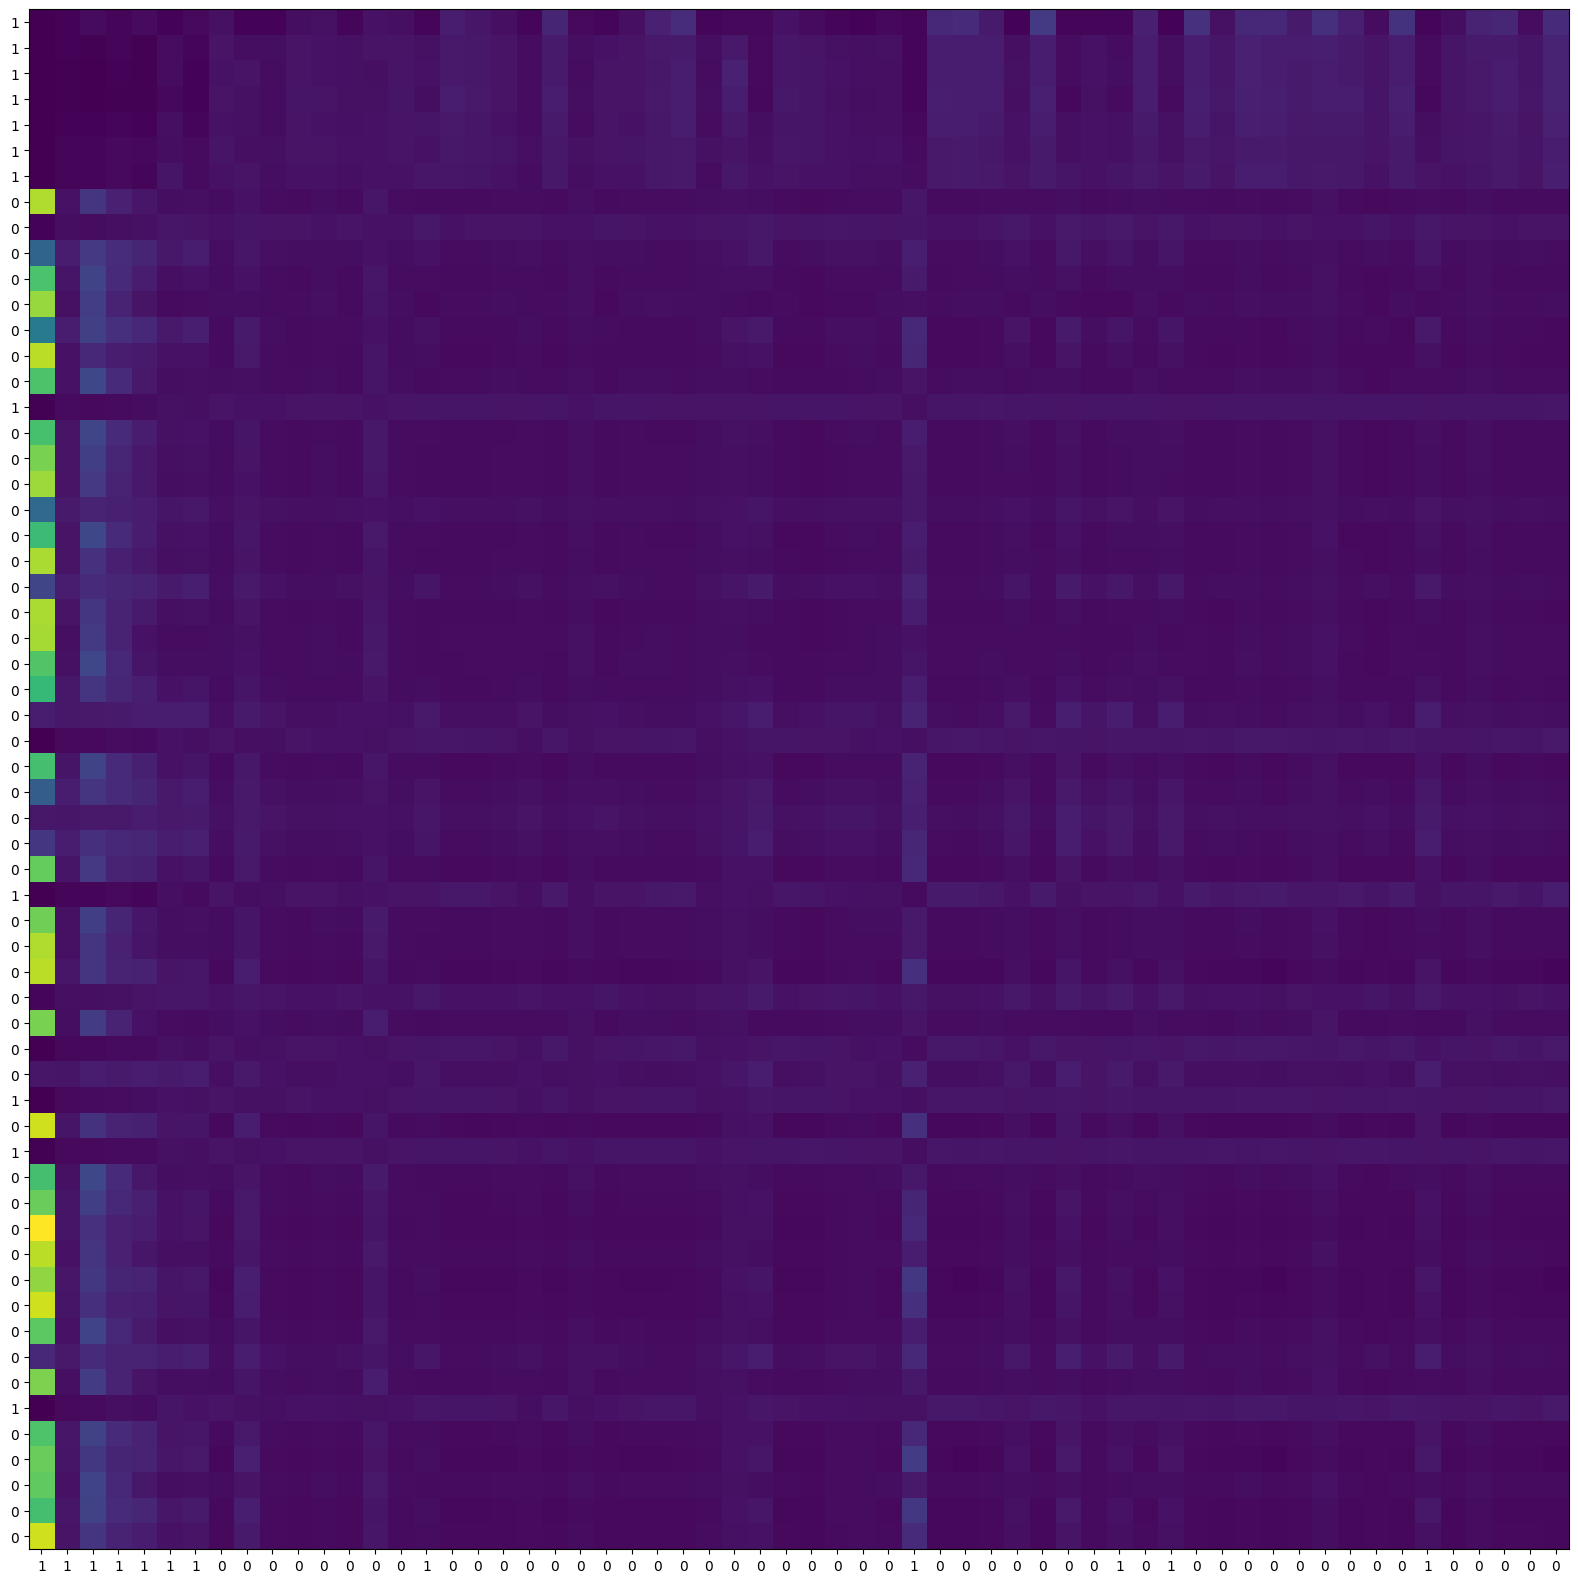

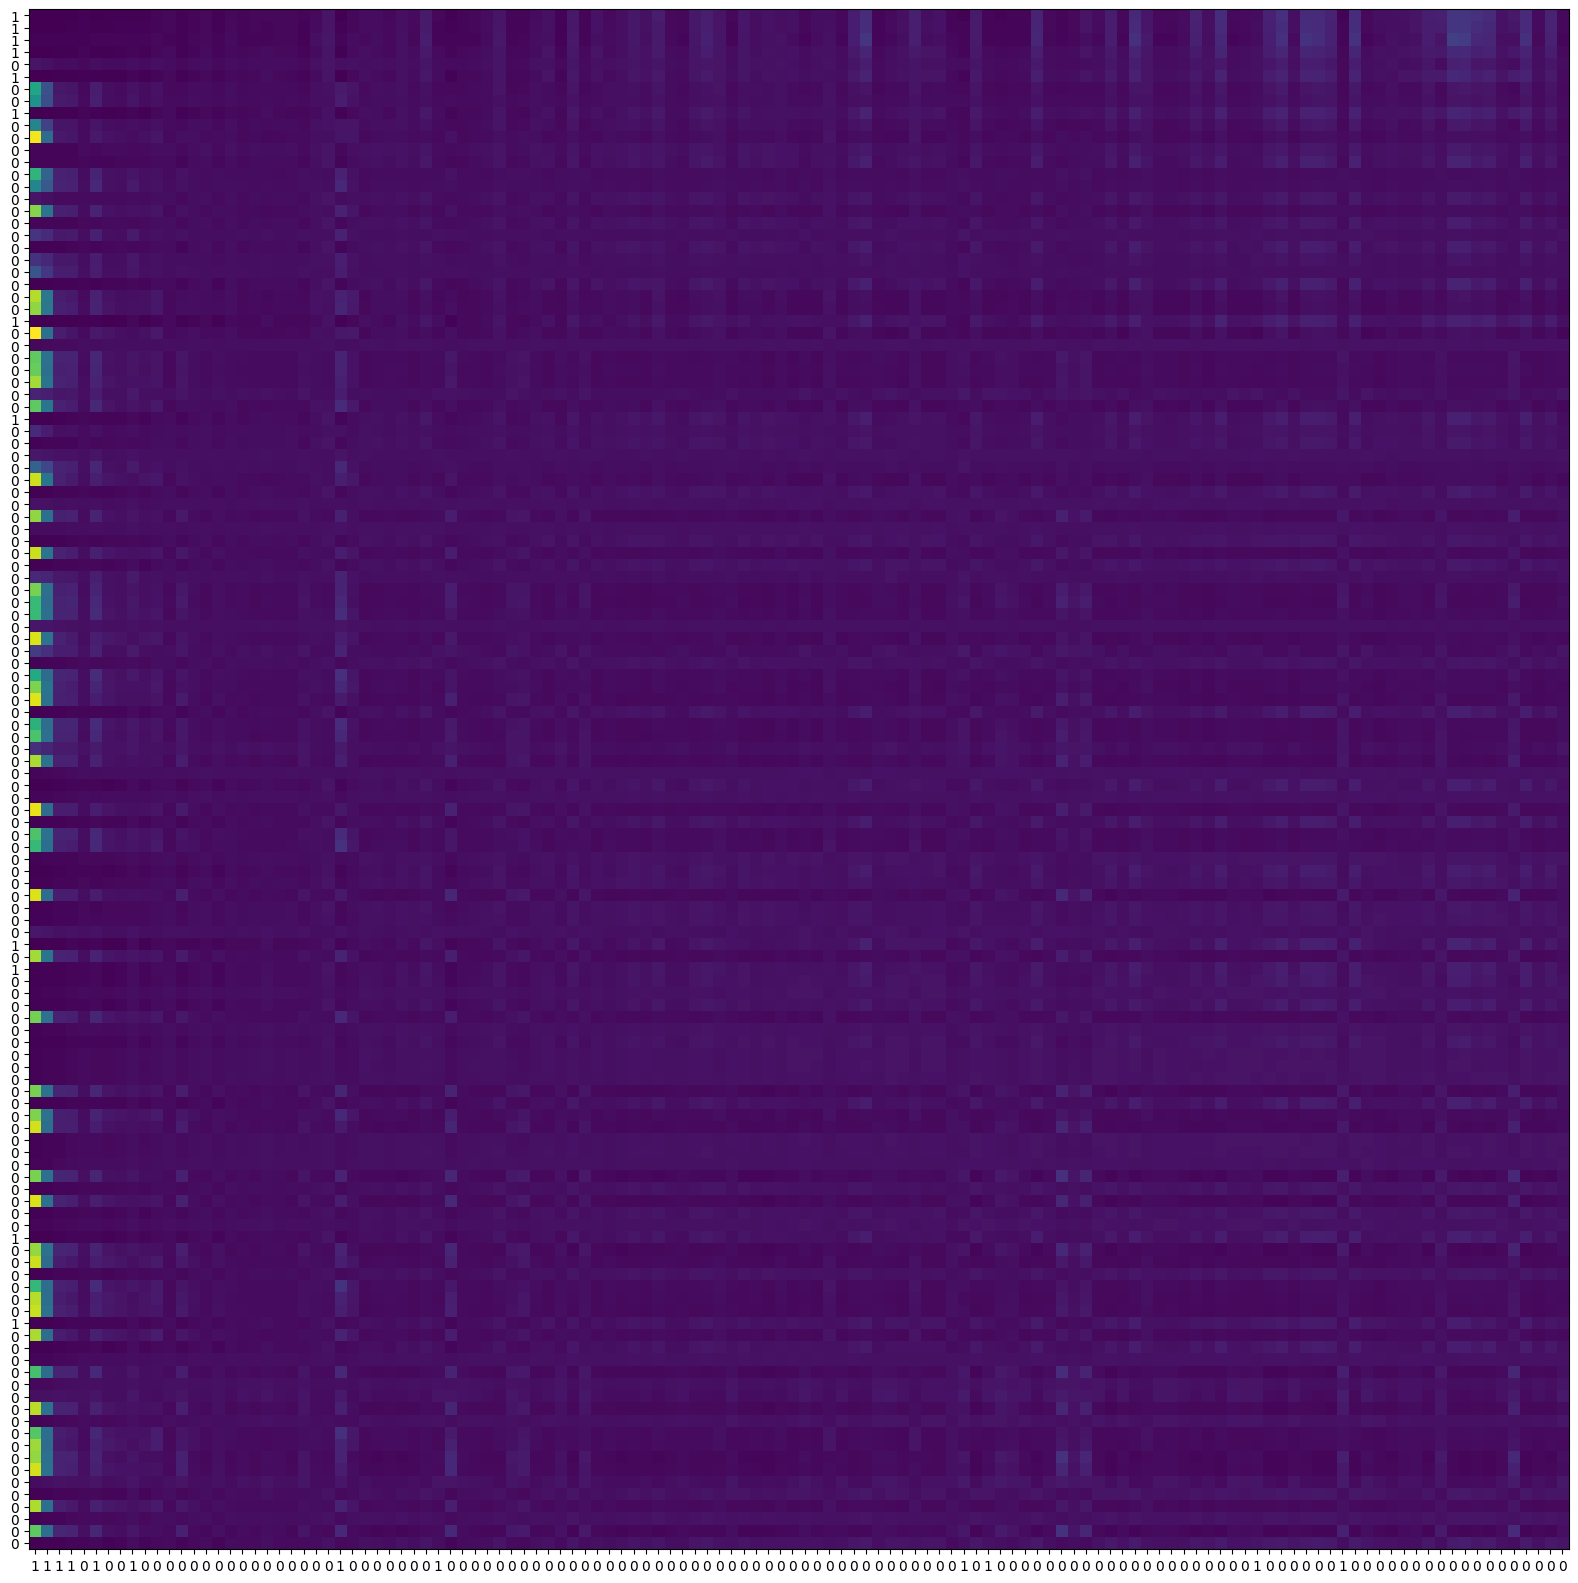

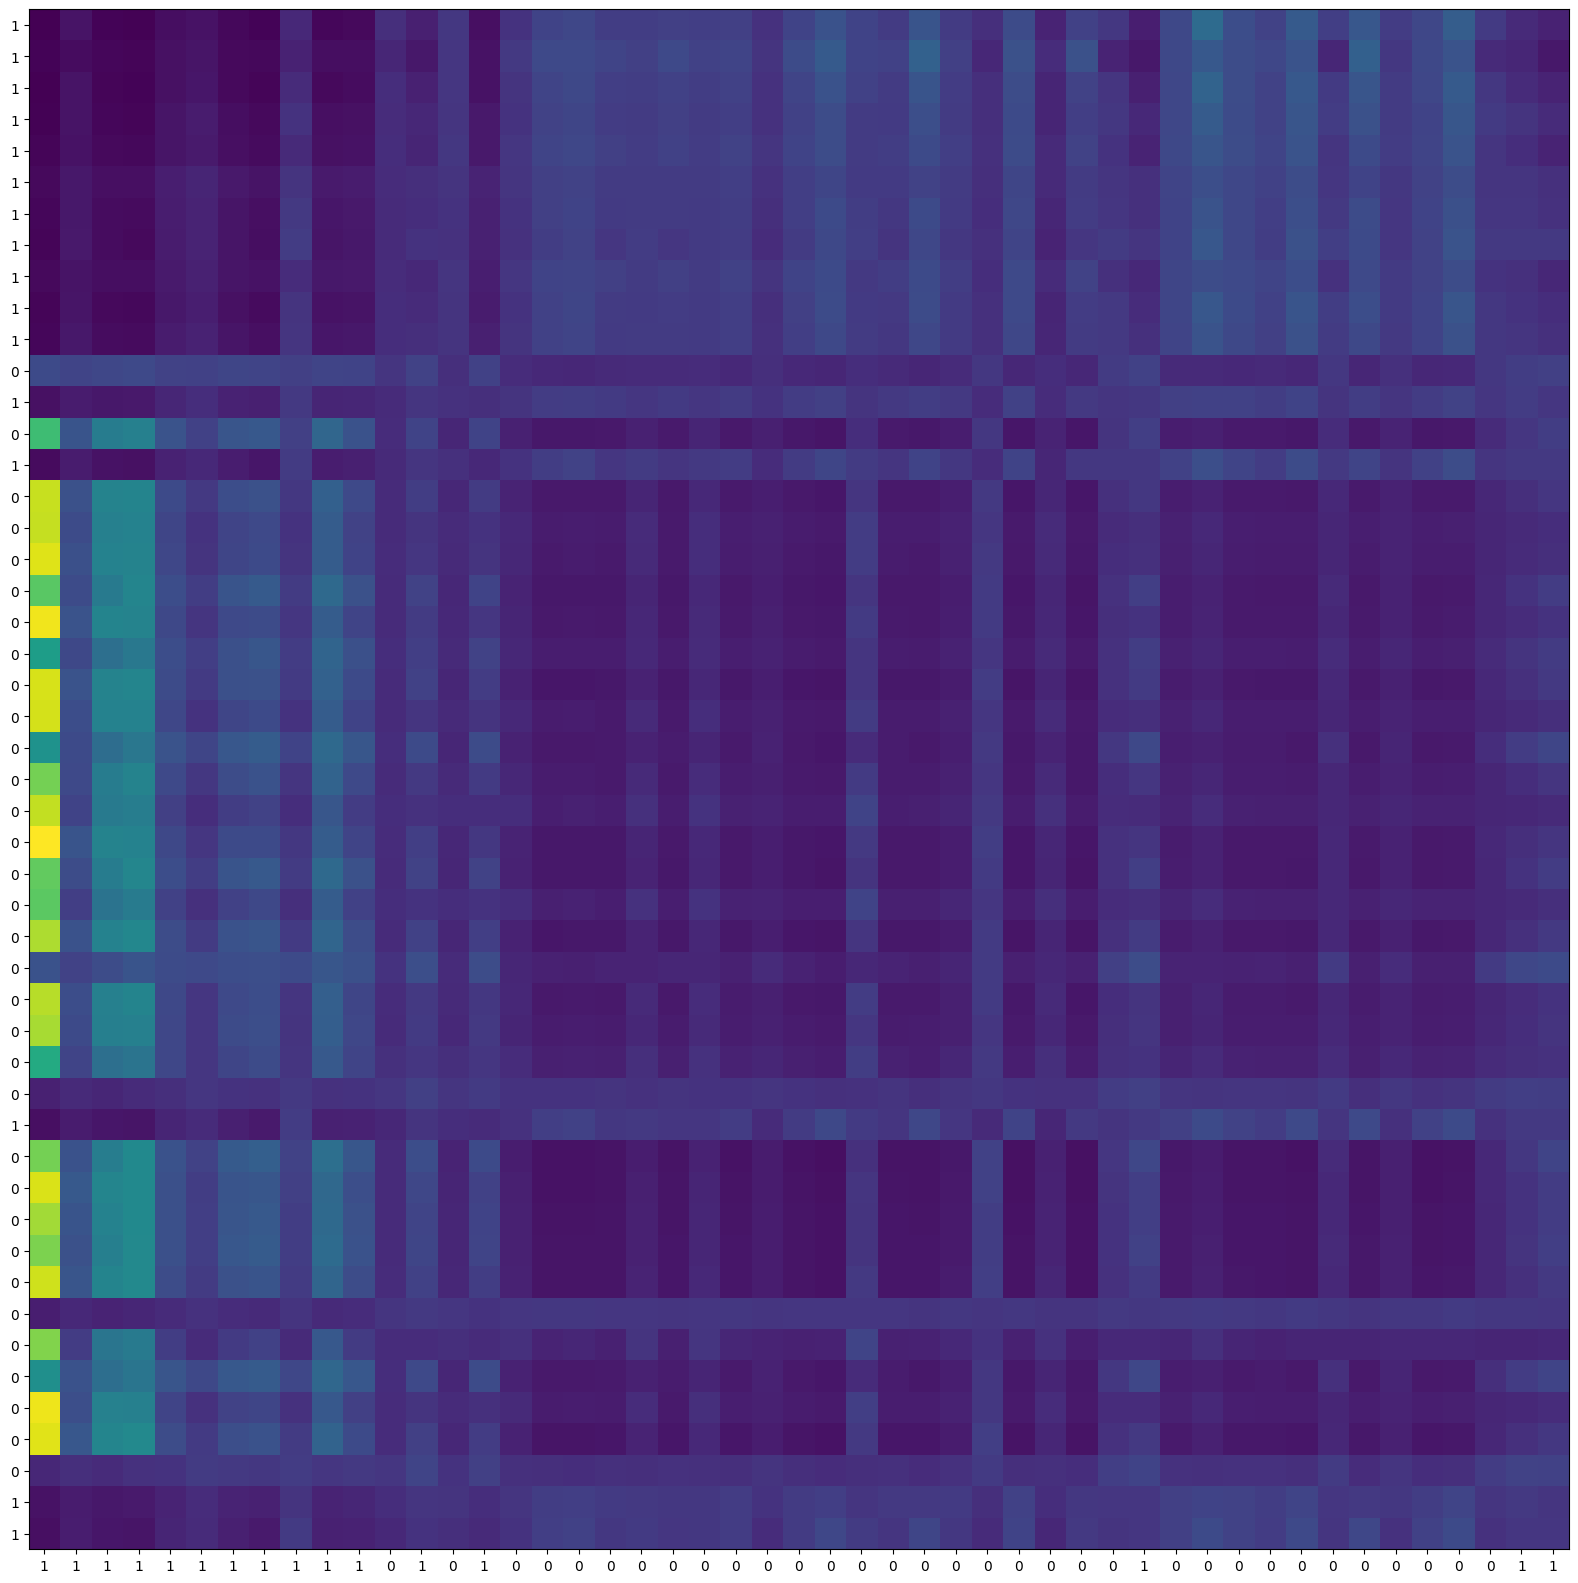

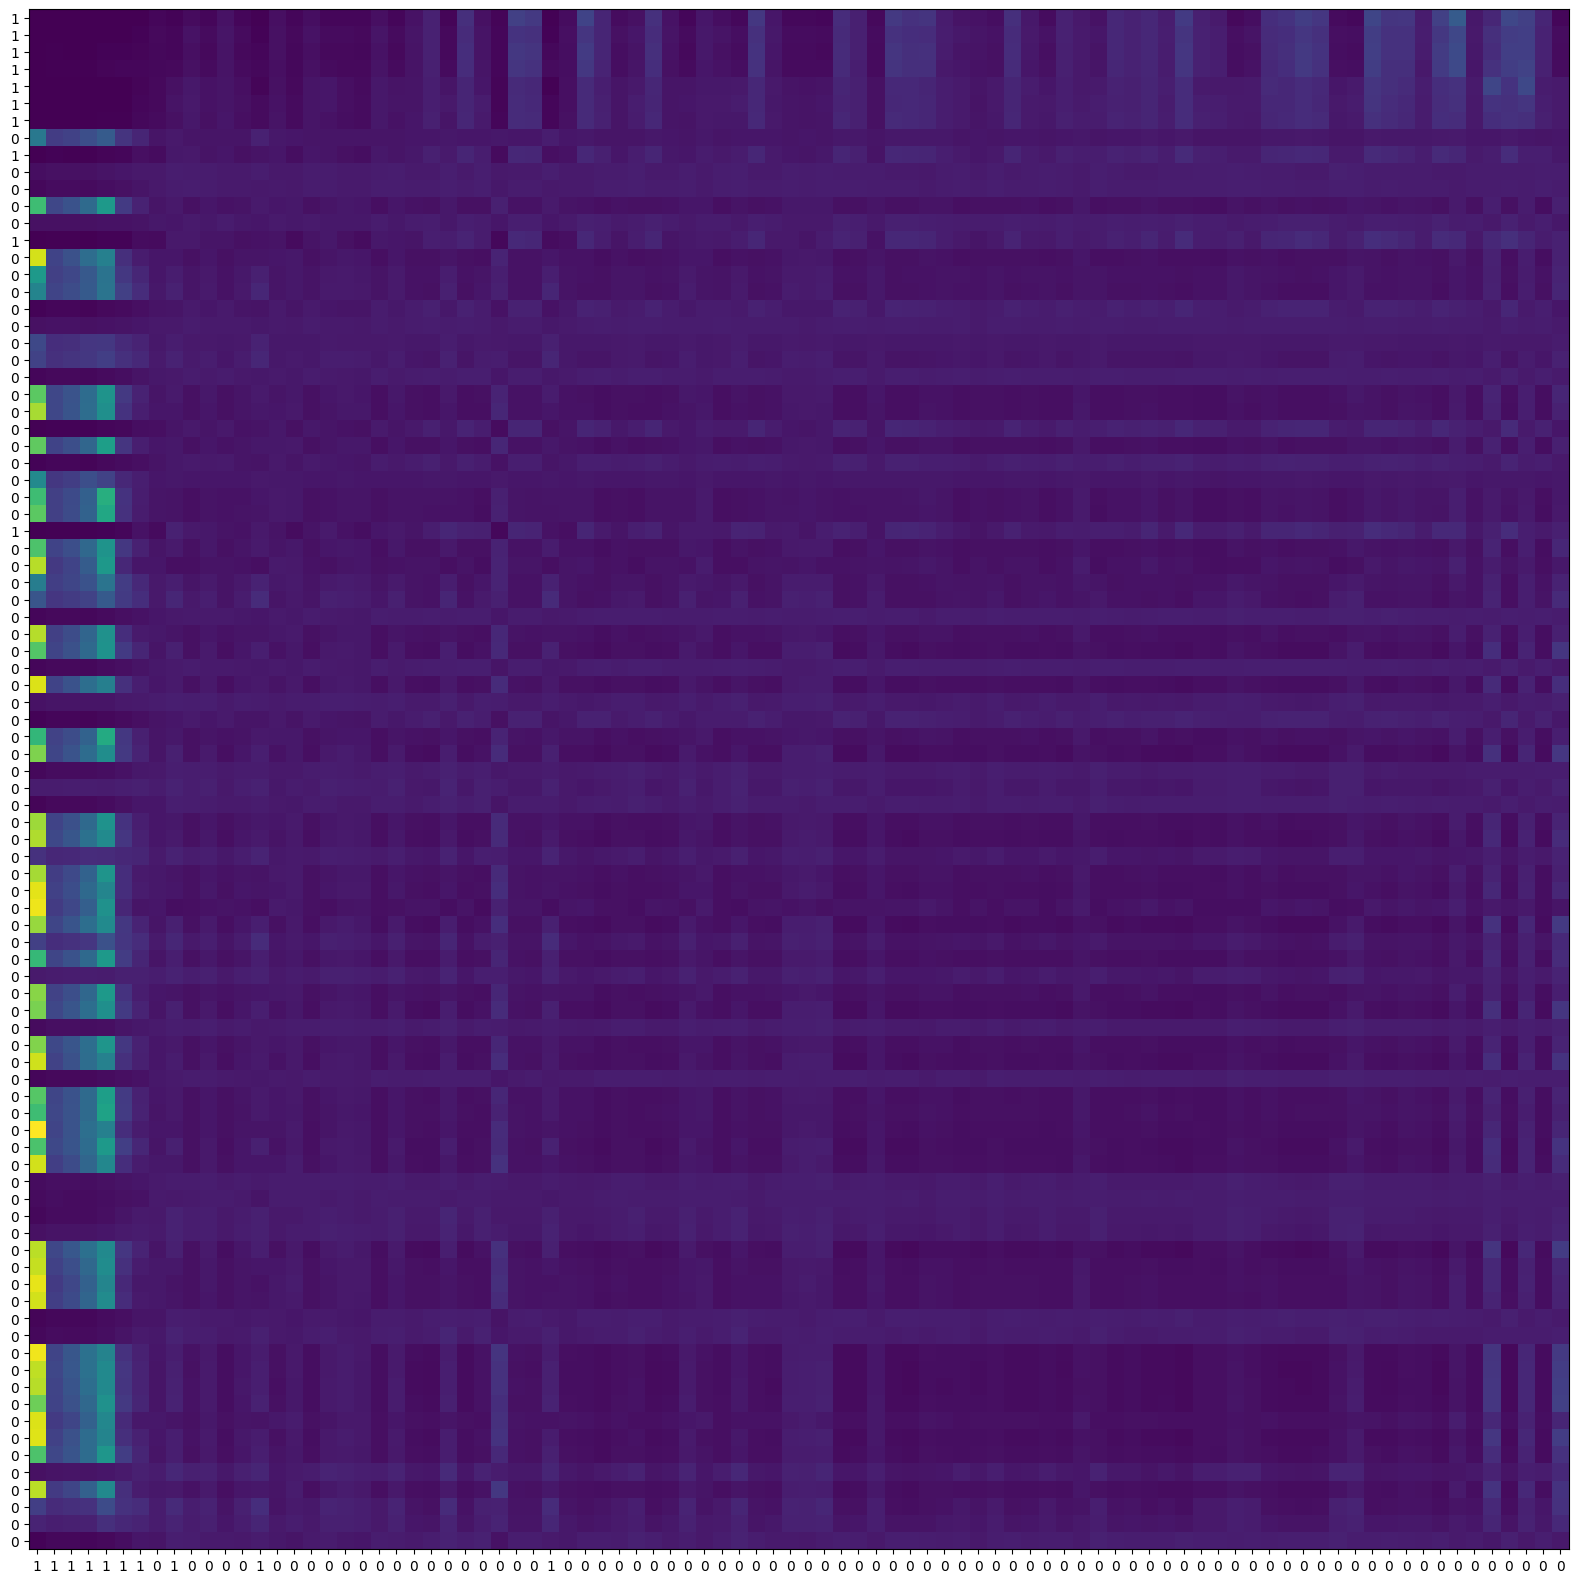

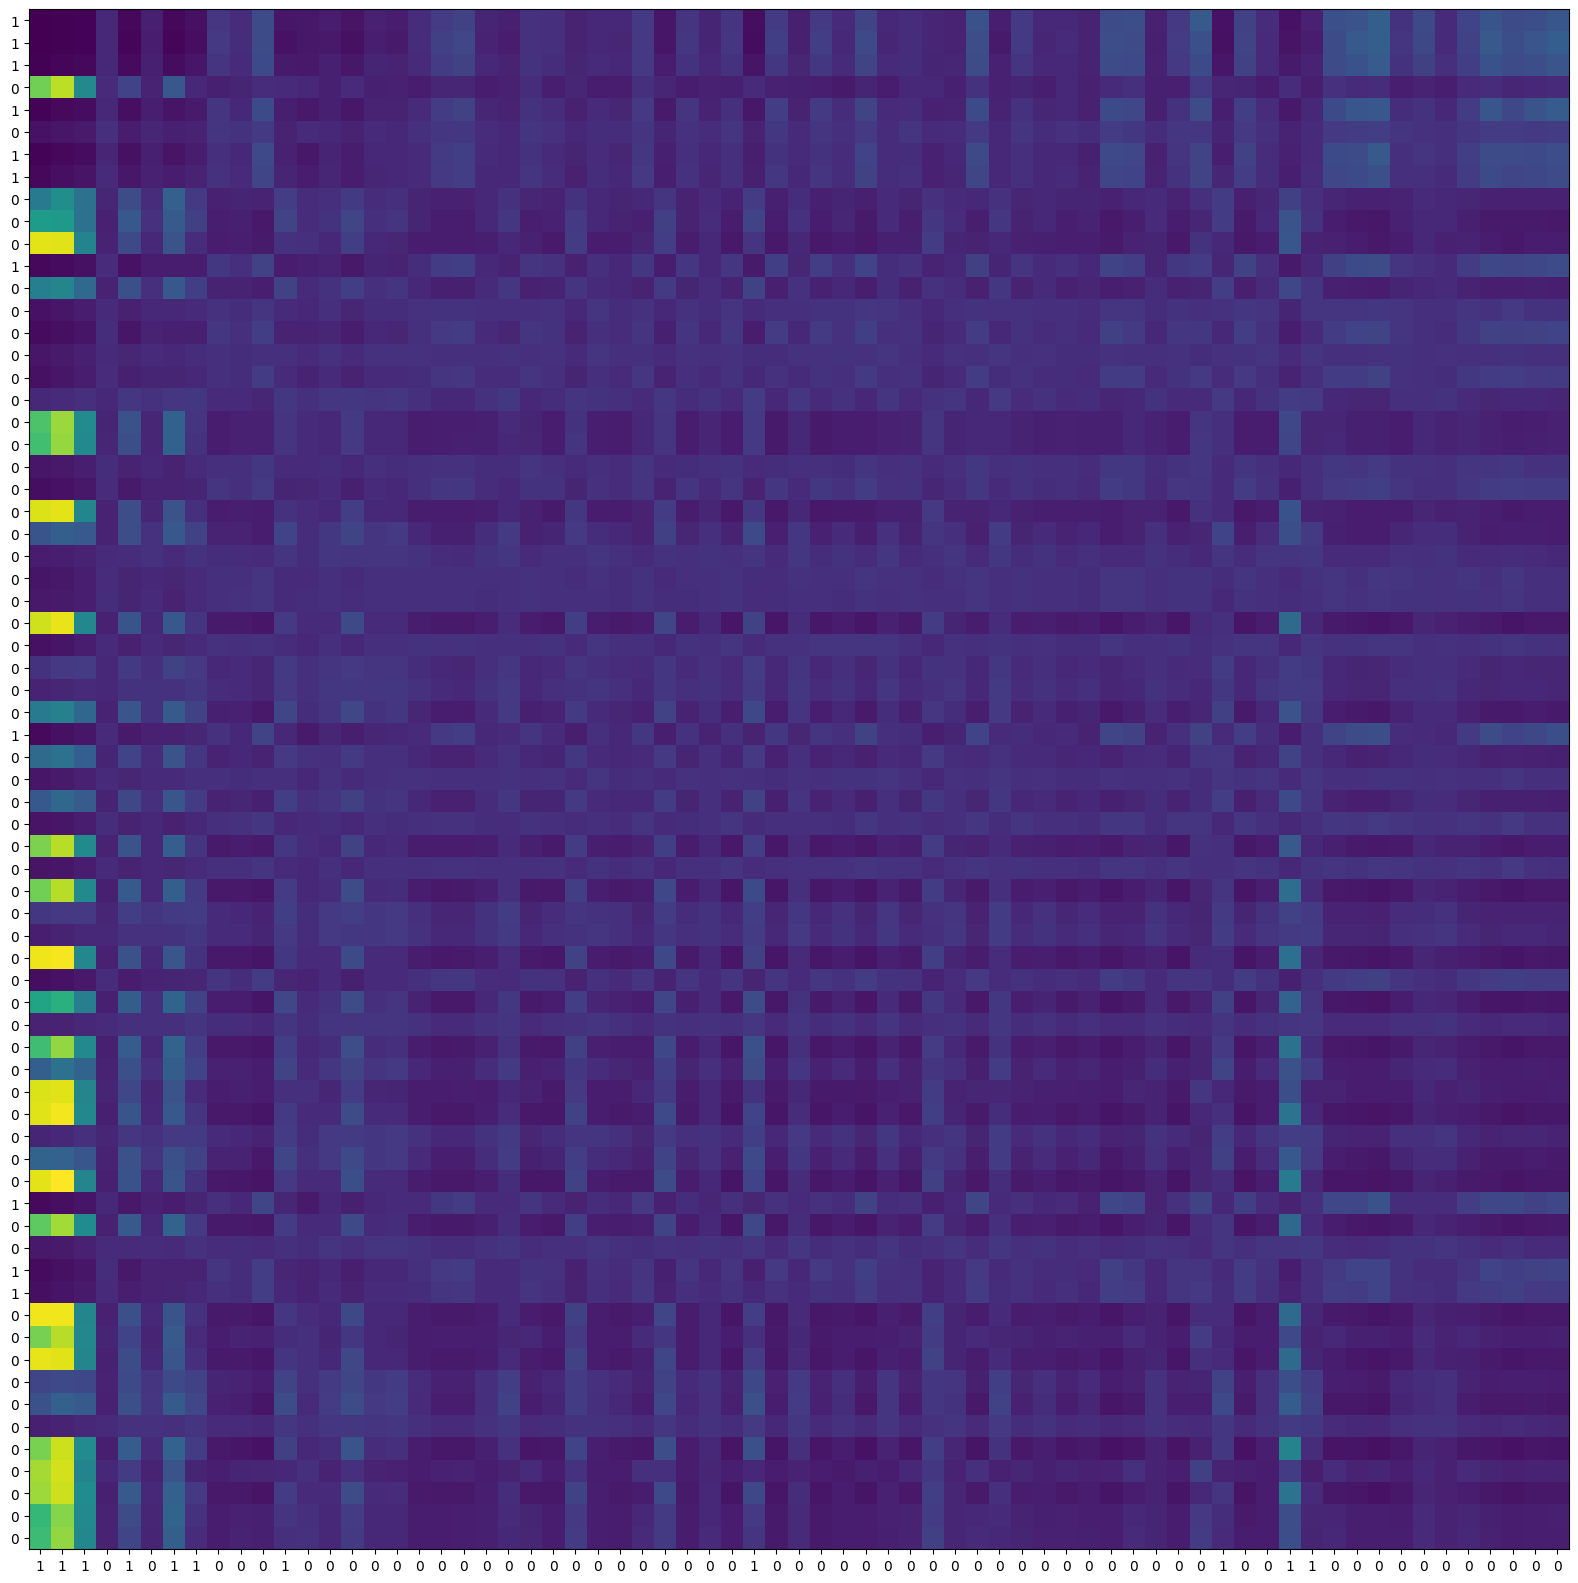

In [19]:
for i in range(5):
    fig = plt.figure(figsize=(20,20))
    plt.imshow(weights[i])
    labels = y_test[i].detach().numpy().astype(int)
    plt.xticks(np.arange(len(labels)),labels)
    plt.yticks(np.arange(len(labels)),labels)
    plt.show()